# Plotting results of predictions


In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from datacube.utils.cog import write_cog

## Calculate net ecosystem exchange

In [ ]:
# gpp = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/GPP_2003_2021.nc')
# er = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/ER_2003_2021.nc')
# nee = (gpp - er) * -1 # reverse sign so that -ve is carbon sink
# nee.name = 'NEE'
# nee.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/NEE_2003_2021.nc')

## Analysis Parameters

In [8]:
var = 'ER'
results_name = 'GPP_2003_2021.nc'
data_path = '/g/data/os22/chad_tmp/NEE_modelling/results/prediction_data/prediction_data_2002-10_2021.nc'

### Open predictions

In [9]:
ds = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+results_name)

### Create a mask

In [10]:
data = xr.open_dataset(data_path)
mask = data.lai.isnull().any('time')

## Facet plots

In [ ]:
year='2011'
ds.sel(time=year).plot.imshow(col='time', col_wrap=6, robust=True); #cmap='RdBu_r'

In [ ]:
year='2019'
ds.sel(time=year).plot.imshow(col='time', col_wrap=6, robust=True);

## Zonal summaries

In [ ]:
ds_1D = ds.sum(['x','y'])

In [ ]:
ds_1D.plot(figsize=(15,5), marker='o', linestyle='--')
# plt.axhline(0, c='grey')
plt.title(var)
plt.ylabel('gC/m2/month');


In [ ]:
ds_1D_annual = ds_1D.resample(time='1Y').sum()
ds_1D_annual.plot(figsize=(15,5), marker='o', linestyle='--')
# plt.axhline(0, c='grey')
plt.title(var)
plt.ylabel('gC/m2/year');

In [ ]:
# y = monthly_mean.where(~mask).sum(['x','y']).values
# x = monthly_mean.month.values
# std = monthly_std.where(~mask).sum(['x','y']).values

# fig,ax = plt.subplots(1,1, figsize=(10,5))
# ax.plot(x, y, marker='o', linestyle='--')
# ax.axhline(0, c='grey')
# ax.fill_between(x, y-std, y+std, alpha=0.5)
# ax.set_title('Monthly Mean NEE summed over Australia');

## Per-pixel summaries

In [ ]:
annual_mean = ds.groupby('time.year').sum().mean('year')
annual_std = ds.groupby('time.year').sum().std('year')

In [ ]:
# write_cog(annual_mean, '/g/data/os22/chad_tmp/NEE_modelling/results/predictions/NEE_annual_mean.tif')
# write_cog(annual_std, '/g/data/os22/chad_tmp/NEE_modelling/results/predictions/NEE_annual_std.tif')

In [ ]:
fig,ax = plt.subplots(1,2, figsize=(25,10))
annual_mean.where(annual_mean>0).plot.imshow(ax=ax[0], robust=True)
annual_std.where(annual_std>0).plot.imshow(ax=ax[1], cmap='magma', robust=True)
ax[0].set_title('Annual Mean '+var+', 2003-2021')
ax[1].set_title('Annual Std. in '+var+', 2003-2021')
# plt.suptitle('Annual Mean and Std. Dev. of GPP, 2003-2021')
plt.tight_layout();

In [11]:
monthly_mean = ds.groupby('time.month').mean()
monthly_std = ds.groupby('time.month').std()

/apps/python3/3.9.2/lib/python3.9/site-packages/numpy-1.20.0-py3.9-linux-x86_64.egg/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/apps/python3/3.9.2/lib/python3.9/site-packages/numpy-1.20.0-py3.9-linux-x86_64.egg/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/apps/python3/3.9.2/lib/python3.9/site-packages/numpy-1.20.0-py3.9-linux-x86_64.egg/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/apps/python3/3.9.2/lib/python3.9/site-packages/numpy-1.20.0-py3.9-linux-x86_64.egg/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/apps/python3/3.9.2/lib/python3.9/site-packages/numpy-1.20.0-py3.9-linux-x86_64.egg/

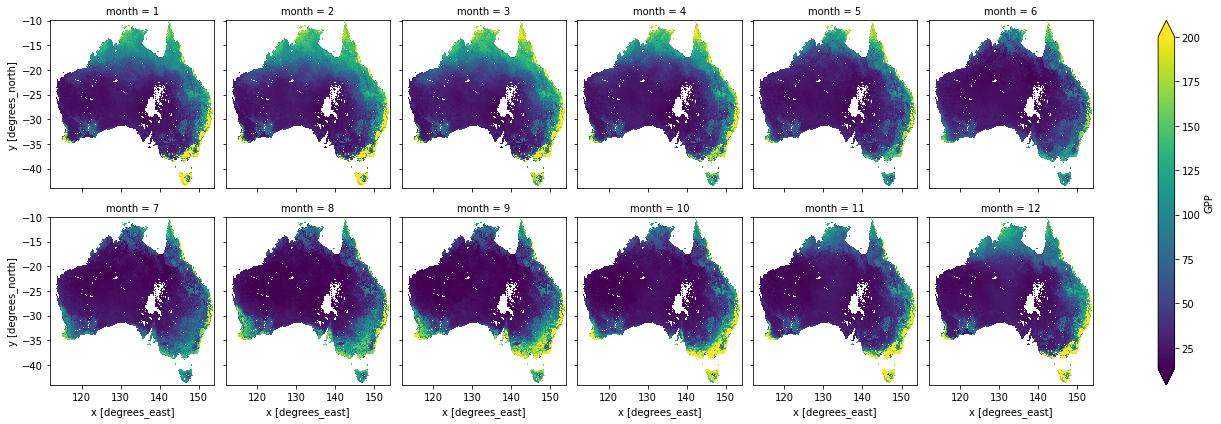

In [14]:
monthly_mean.where(~mask).plot.imshow(col='month', col_wrap=6, robust=True, vmax=200); #cmap='RdBu_r'

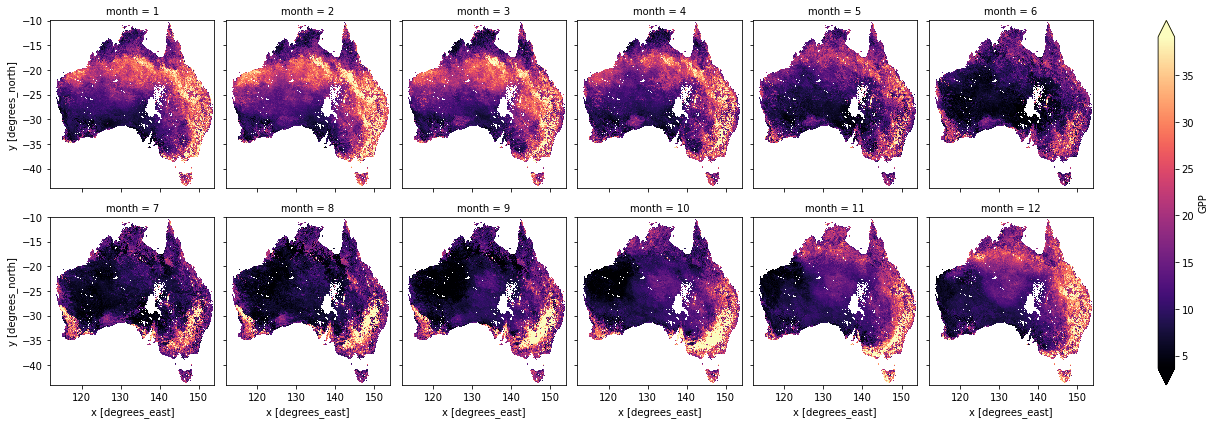

In [15]:
monthly_std.where(~mask).plot.imshow(col='month', col_wrap=6,robust=True, cmap='magma');

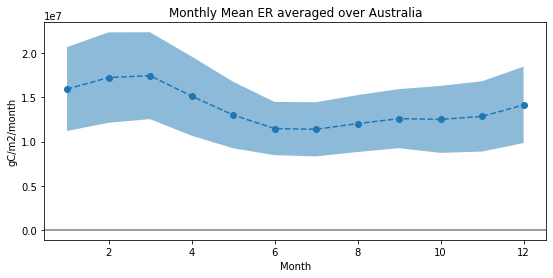

In [13]:
y = monthly_mean.where(~mask).sum(['x','y']).values
x = monthly_mean.month.values
std = monthly_std.where(~mask).sum(['x','y']).values

fig,ax = plt.subplots(1,1, figsize=(9,4))
ax.plot(x, y, marker='o', linestyle='--')
ax.axhline(0, c='grey')
ax.fill_between(x, y-std, y+std, alpha=0.5)
ax.set_title('Monthly Mean '+var+' averaged over Australia')
ax.set_xlabel('Month');
ax.set_ylabel('gC/m2/month');


## Fluxcom

In [ ]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
var = 'nee'
ds = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/FLUXCOM/'+var+'_rs_meteo_era5.nc').sel(time=slice('2003','2018'))

In [ ]:
var='NEE'
monthly_mean = ds[var].groupby('time.month').mean()
monthly_std = ds[var].groupby('time.month').std()

y = monthly_mean.mean(['lat','lon']).values
x = monthly_mean.month.values
std = monthly_std.mean(['lat','lon']).values

fig,ax = plt.subplots(1,1, figsize=(9,4))
ax.plot(x, y, marker='o', linestyle='--')
ax.axhline(0, c='grey')
ax.fill_between(x, y-std, y+std, alpha=0.5)
ax.set_title('Monthly Mean '+var+' averaged over Australia')
ax.set_xlabel('Month');
ax.set_ylabel('gC/m2/day');

In [ ]:
y = monthly_mean.mean(['lat','lon']).values
x = monthly_mean.month.values
std = monthly_std.mean(['lat','lon']).values

fig,ax = plt.subplots(1,1, figsize=(9,4))
ax.plot(x, y, marker='o', linestyle='--')
ax.axhline(0, c='grey')
ax.fill_between(x, y-std, y+std, alpha=0.5)
ax.set_title('Monthly Mean NEE averaged over Australia')
ax.set_xlabel('Month');
ax.set_ylabel('gC/m2/month');

In [ ]:
nee_1D = nee.NEE.sum(['lat','lon']) * 30
nee_1D.plot(figsize=(15,5), marker='o', linestyle='--')
plt.axhline(0, c='grey')
plt.title('Fluxcom NEE')
plt.ylabel('gC/m2/month');

In [ ]:
nee_1D_annual = nee_1D.resample(time='1Y').sum() * 365 
nee_1D_annual.plot(figsize=(15,5), marker='o', linestyle='--')
plt.axhline(0, c='grey')
plt.title('Fluxcom NEE')
plt.ylabel('gC/m2/year');

In [ ]:
year='2011'
nee.NEE.sel(time=year).plot.imshow(col='time', col_wrap=6, robust=True, cmap='RdBu_r');

In [ ]:
annual_mean = nee.NEE.groupby('time.year').sum().mean('year')
annual_std = nee.NEE.groupby('time.year').sum().std('year')

In [ ]:
# from odc.geo.xr import assign_crs
# write_cog(assign_crs(annual_std, crs='epsg:4326'), '/g/data/os22/chad_tmp/NEE_modelling/results/predictions/FUXCOM_NEE_annual_std.tif')

In [ ]:
fig,ax = plt.subplots(1,2, figsize=(25,10))
annual_mean.plot.imshow(ax=ax[0], robust=True)
annual_std.where(annual_std > 0).plot.imshow(ax=ax[1], cmap='magma', robust=True)
ax[0].set_title('Annual Mean NEE, 2000-2018')
ax[1].set_title('Annual Std. Dev. in NEE, 2000-2018')
plt.tight_layout();

## SIF

In [ ]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
sif = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/SIF/GOSIF_2000_2020.nc').sel(time=slice('2003','2021'))

In [ ]:
sif_1D = sif.sum(['x','y'])
sif_1D.plot(figsize=(15,5), marker='o', linestyle='--')
# plt.axhline(0, c='grey')
plt.title('GO-SIF');

In [ ]:
sif_1D_annual = sif_1D.resample(time='1Y').sum() 
sif_1D_annual.plot(figsize=(15,5), marker='o', linestyle='--')
# plt.axhline(0, c='grey')
plt.title('GOSIF');